In [1]:
# DATA
import pandas as pd 
import numpy as np
from sklearn.preprocessing import LabelEncoder
import gc
from xgboost import XGBRegressor

train_df = pd.read_csv("train.csv")
test_df  = pd.read_csv("test.csv")

le = LabelEncoder()
numerical_cols = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
categorical_cols = ['Sex']

def feature_engineering(df,catboost=False,xgb_best=False,dumb_model=False):  
    
    for c in categorical_cols:
        #df[c] = le.fit_transform(df[c]) # Converts categorical column into int format
        df[c] = df[c].astype('category') # Define column type as category 
        df[c] = df[c].cat.codes

    if dumb_model:
        df['BMI'] = df['Weight'] / (df['Height'] / 100) ** 2
        df['Intensity'] = df['Heart_Rate'] / df['Duration']

    if catboost:
        df['BMI'] = df['Weight'] / (df['Height'] / 100) ** 2
        df['Intensity'] = df['Heart_Rate'] / df['Duration']

        df['Age_bin6'] = pd.qcut(df['Age'], q=6, labels=[1, 2, 3, 4, 5, 6]).astype(int)
        df['Height_log10p'] = np.log10(df['Height']).astype(float)
        df['Sex_Weight_prod'] = df['Sex'] * df['Weight']
        df['Sex_Age_log10p_sum'] = df['Sex'] + np.log10(df['Age']).astype(float)
        df['Sex_Age_bin6_sum'] = df['Sex'] + pd.qcut(df['Age'], q=6, labels=[1, 2, 3, 4, 5, 6]).astype(int)
        df['Sex_Duration_log10p_prod'] = df['Sex'] * np.log10(df['Duration']).astype(float)
        df['Sex_Body_Temp_log10p_prod'] = df['Sex'] * np.log10(df['Body_Temp']).astype(float)
        df['Age_Age_bin6_ratio'] = df['Age'] / pd.qcut(df['Age'], q=6, labels=[1, 2, 3, 4, 5, 6]).astype(int)
        df['Height_Height_log10p_prod'] = df['Height'] * np.log10(df['Height']).astype(float)
        df['Height_Height_bin6_ratio'] = df['Height'] / pd.qcut(df['Height'], q=6, labels=[1, 2, 3, 4, 5, 6]).astype(int)
        df['Height_Duration_log1p_sum'] = df['Height'] + np.log1p(df['Duration'].astype(float))
        df['Heart_Rate_log10p_Duration_ratio'] = np.log10(df['Heart_Rate']).astype(float) / df['Duration']
        df['Body_Temp_bin6_Duration_ratio'] = pd.qcut(df['Body_Temp'], q=6, labels=[1, 2, 3, 4, 5, 6]).astype(int) / df['Duration']
        df['Heart_Rate_Heart_Rate_log10p_prod'] = df['Heart_Rate'] * np.log10(df['Heart_Rate']).astype(float)
        df['Body_Temp_Height_log10p_prod'] = df['Body_Temp'] * np.log10(df['Height']).astype(float)
        df['Body_Temp_Height_log1p_ratio'] = df['Body_Temp'] / np.log1p(df['Height']).astype(float)
        df['Body_Temp_Heart_Rate_log10p_diff'] = df['Body_Temp'] - np.log10(df['Heart_Rate']).astype(float)
        df['Age_bin6_Weight_log10p_diff'] = pd.qcut(df['Age'], q=6, labels=[1, 2, 3, 4, 5, 6]).astype(int) - np.log10(df['Weight']).astype(float)

    if xgb_best:
        for i in range(len(numerical_cols)):
            for j in range(i + 1, len(numerical_cols)):  
                feature1 = numerical_cols[i]
                feature2 = numerical_cols[j]
                cross_term_name = f"{feature1}_x_{feature2}"
                df[cross_term_name] = df[feature1] * df[feature2]
 

    gc.collect()
    return df

catboost_test = test_df.copy()
catboost_train = train_df.copy()
catboost_test = feature_engineering(catboost_test,catboost=True)
catboost_train = feature_engineering(catboost_train,catboost=True)

xgb_best_test = test_df.copy()
xgb_best_train = train_df.copy()
xgb_best_test = feature_engineering(xgb_best_test,xgb_best=True)
xgb_best_train = feature_engineering(xgb_best_train,xgb_best=True)

xgb_dumb_test = test_df.copy()
xgb_dumb_train = train_df.copy()
xgb_dumb_test =  feature_engineering(xgb_dumb_test,dumb_model=True)
xgb_dumb_train = feature_engineering(xgb_dumb_train,dumb_model=True)

"""test_df = feature_engineering(test_df)
train_df = feature_engineering(train_df)

labels = train_df['Calories']
train_df.drop('Calories',axis=1,inplace=True)

train_df.describe()"""


"test_df = feature_engineering(test_df)\ntrain_df = feature_engineering(train_df)\n\nlabels = train_df['Calories']\ntrain_df.drop('Calories',axis=1,inplace=True)\n\ntrain_df.describe()"

In [2]:
import xgboost as xgb
import catboost as cb 

"""first_model = xgb.XGBRegressor()
first_model.load_model("models/XGB_first.json")
"""


first_model = xgb.XGBRegressor()
first_model.load_model("models/best_xgb.json")

second_model = cb.CatBoostRegressor()
second_model.load_model("models/catboost.json")

third_model = cb.CatBoostRegressor()
third_model.load_model("models/catboost_new.json")


In [3]:
preds1 = first_model.predict(xgb_best_test.drop("id",axis=1))

preds2 = second_model.predict(catboost_test.drop("id",axis=1))

preds3 = third_model.predict(catboost_test.drop(["id"],axis=1))

ids = test_df["id"]

In [4]:
df = pd.DataFrame({
    "xgb_best":preds1,
    #"cb":preds2,
    "cb_new":preds3 

})
df.to_csv("test_preds/gbdt.csv")

In [5]:
if False:
    oofs_cb = third_model.predict(catboost_train.drop(["id","Calories"],axis=1))
    oofs_xgb = first_model.predict(xgb_best_train.drop(["id","Calories"],axis=1))
    oofs_xgb_dumb = second_model.predict(xgb_dumb_train.drop(["id","Calories"],axis=1))

    oofs_cb = np.expm1(oofs_cb)
    oofs_xgb = np.expm1(oofs_xgb)
    oofs_xgb_dumb = np.expm1(oofs_xgb_dumb)

    oofs_cb = pd.DataFrame({"cb":oofs_cb})
    oofs_xgb = pd.DataFrame({"xgb":oofs_xgb})
    oofs_xgb_dumb = pd.DataFrame({"xgb_dumb":oofs_xgb_dumb})

    oofs_cb.to_csv("oofs/catboost_oofs.csv")
    oofs_xgb.to_csv("oofs/xgb_oofs.csv")
    oofs_xgb_dumb.to_csv("oofs/xgb_dumb_oofs.csv")

In [6]:
import numpy as np

preds1 = np.maximum(preds1, 0)
preds2 = np.maximum(preds2, 0)
preds3 = np.maximum(preds3, 0)


pred1_weighted = preds1*0.50
#pred2_weighted = preds2*0.50
pred3_weighted = preds3*0.50


ensemble_preds = np.expm1(pred1_weighted + pred3_weighted)

submission = pd.DataFrame({"id": test_df["id"], "prediction": np.expm1(preds3)})

submission.to_csv("submission_bok.csv", index=False)


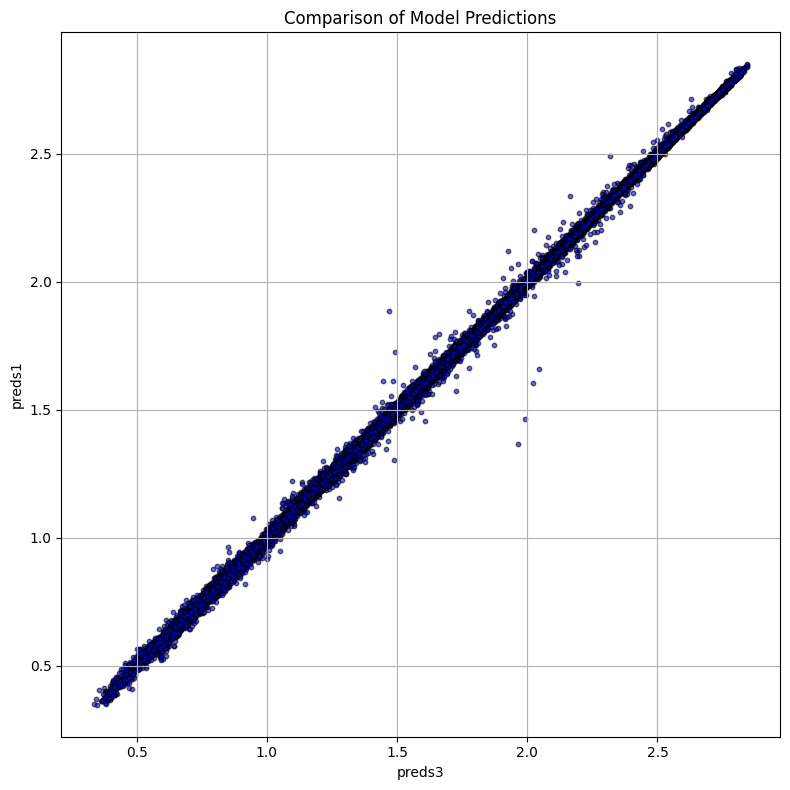

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(pred3_weighted , pred1_weighted , s=10, alpha=0.6, c='blue', edgecolors='k')
#plt.plot([min(preds1), max(preds1)], [min(preds1), max(preds1)], color='red', linestyle='--')  # y = x line
plt.title("Comparison of Model Predictions")
plt.xlabel("preds3")
plt.ylabel("preds1")
plt.grid(True)
plt.tight_layout()
plt.show()